In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Copy all the files to a local directory, because I don't have the right permissions on RDSF

"""

import os
import yaml
import shutil
import pathlib
from tqdm import tqdm

# Create an output file directory
battery_dir = "data/battery_dbs/"
if not os.path.isdir(battery_dir):
    os.makedirs(battery_dir)

# Find all the files
with open("config.yaml", "r") as stream:
    dirname = "/mnt/z/" + yaml.safe_load(stream)["smartwatch_dbs_dir"]
dirname = pathlib.Path(dirname)
assert dirname.exists()

# Recurse into all "Week X" directories, extracting all .db files
source_files = [file for file in dirname.glob("Week*/**/*.db")]
dest_files = [os.path.join(battery_dir, file.name) for file in source_files]

# Check that they don't all exist
if not all([os.path.isfile(dest) for dest in dest_files]):
    for source, dest in tqdm(zip(source_files, dest_files), total=len(source_files)):
        assert not os.path.isfile(dest), f"Duplicate name {source}"
        shutil.copyfile(source, dest)

In [3]:
"""
Create a csv of p_id, timestamp and battery level

"""

import sqlite3
import pandas as pd


dfs = []

for path in tqdm(dest_files):
    # Get the p_id from the path
    path = pathlib.Path(path)
    p_id = path.name.split("_")[1]

    # Open the db
    conn = sqlite3.connect(path, uri=True)

    # Get the battery level
    try:
        df = pd.read_sql_query("SELECT * FROM Event;", conn)

    except pd.io.sql.DatabaseError as e:
        print(f"{path} failed with {e}")
        continue

    # Only keep battery level rows
    df = df[df["eventdesc"].str.startswith("B")]

    # Add a new column for timestamp
    df["Datetime"] = pd.to_datetime(
        df["eventdate"] + " " + df["eventtime"], format="%Y-%m-%d %H:%M:%S"
    )
    df["battery_lvl"] = df["eventdesc"].str.split(" ").str[-1].str[:-1].astype(int)

    df["p_id"] = p_id

    dfs.append(df[["p_id", "Datetime", "battery_lvl"]])

    conn.close()

battery_level_df = pd.concat(dfs)
battery_level_df.head()

 79%|███████▉  | 61/77 [00:00<00:00, 303.12it/s]

data/battery_dbs/EMADATA_15082_20220420.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_20050_20220412.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_29061_20220628.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_4260_20211221.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_27345_20220615.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_35272_20220520.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_23532_20220204.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_3017_20220204.db failed 

100%|██████████| 77/77 [00:00<00:00, 299.10it/s]

data/battery_dbs/EMADATA_638_20220428.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_9359_20220719.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed


,p_id,Datetime,battery_lvl
2,765,2022-04-12 12:56:52,22
5,765,2022-04-12 12:59:06,25
8,765,2022-04-12 14:01:50,99
12,765,2022-04-12 16:31:37,100
15,765,2022-04-12 17:32:11,99


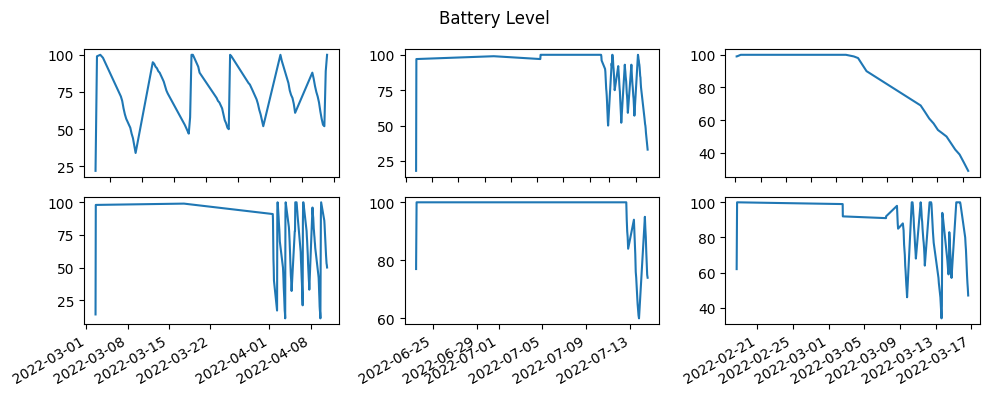

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(10, 4))

for pid, axis in zip(battery_level_df["p_id"].unique(), axes.flat):
    slice_ = battery_level_df[battery_level_df["p_id"] == pid].sort_values("Datetime")
    axis.plot(slice_["Datetime"], slice_["battery_lvl"], "-")

fig.suptitle("Battery Level")

fig.autofmt_xdate()
fig.tight_layout()

imgdir = "img/battery_level"
if not os.path.isdir(imgdir):
    os.makedirs(imgdir)
fig.savefig(f"{imgdir}/battery_level.png")

In [5]:
"""
Find the start day of each participant

"""

from ema import read

battery_df = battery_level_df.copy()
battery_df["p_id"] = battery_df["p_id"].astype(int)
battery_df = battery_df.set_index(battery_df["Datetime"]).drop(columns=["Datetime"])

battery_df = read.add_timedelta(battery_df)
len(battery_df)

5879

In [6]:
"""
Remove negative delta and deltas above 7

"""

battery_df = battery_df[battery_df["delta"].dt.days >= 1]
battery_df = battery_df[battery_df["delta"].dt.days <= 7]
len(battery_df)

4615

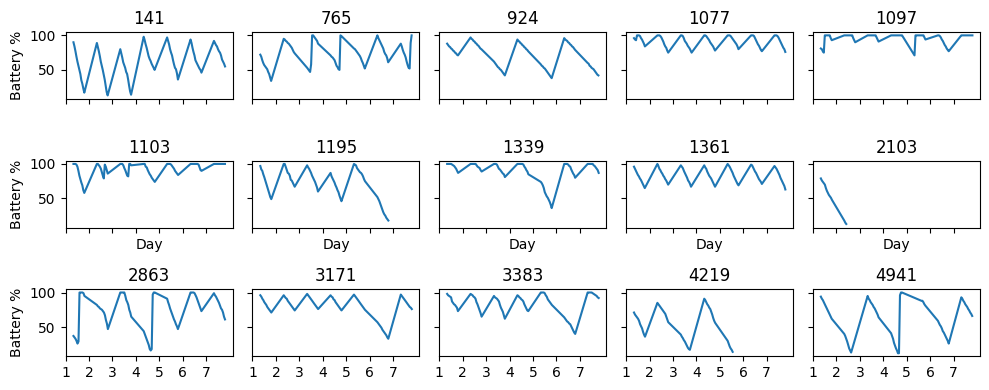

In [7]:
"""
Plot battery level against delta

"""

from itertools import islice
import numpy as np

fig, axes = plt.subplots(3, 5, figsize=(10, 4), sharex=True, sharey=True)

for axis, (p_id, grp) in zip(
    axes.flat, islice(battery_df.groupby("p_id"), len(axes.flat))
):
    axis.plot(grp["delta"].dt.total_seconds(), grp["battery_lvl"])
    axis.set_title(p_id)

for axis in axes[:, 0]:
    axis.set_ylabel("Battery %")
for axis in axes[1]:
    axis.set_xlabel("Day")

# Convert x labels to days
axis.set_xticks(np.arange(1, 8) * 24 * 3600, range(1, 8))

fig.tight_layout()
fig.savefig(f"{imgdir}/battery_level_vs_delta.png")

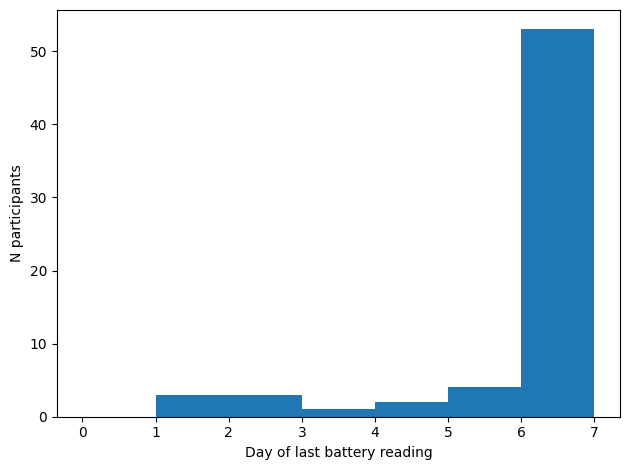

In [8]:
"""
Find the last recording day for each participant

"""

max_delta = battery_df.groupby("p_id")["delta"].max()

fig, axis = plt.subplots()
axis.hist(max_delta.dt.days, bins=range(8))
axis.set_xlabel("Day of last battery reading")
axis.set_ylabel("N participants")

fig.tight_layout()
fig.savefig(f"{imgdir}/last_battery_reading.png")

In [9]:
"""
Find the last entry day of each participant

"""

from ema import clean

# Read in meal entries
meal_df = clean.cleaned_smartwatch(keep_catchups=False)

# Remove the non-responses
meal_df = meal_df[meal_df["meal_type"] != "No response"]

# Find the last entry for each participant
last_entry = meal_df.groupby("p_id")["delta"].max()

/home/mh19137/seaco_malaysia/ema/clean.py:118: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Normal' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  copy.loc[start_time, col_name] = "Normal"
/home/mh19137/seaco_malaysia/ema/clean.py:189: UserWarning: Long catchup: not marking Meal at 2022-05-19 09:02:49 as catchup
  warnings.warn(


 Open ended catchup at 2022-02-11 20:02:05 ended by No response at 2022-02-12 08:02:11
 Open ended catchup at 2022-02-14 20:26:30 ended by No response at 2022-02-15 08:02:16
 Open ended catchup at 2022-04-19 08:01:14 ended by No catch-up at 2022-04-19 08:01:17
 Open ended catchup at 2022-06-27 15:53:14 ended by Catch-up start at 2022-06-27 15:54:06
 Open ended catchup at 2021-12-31 22:11:10 ended by No catch-up at 2022-01-01 08:01:15
 Open ended catchup at 2022-05-24 07:25:36 ended by Catch-up start at 2022-05-24 07:26:00
 Open ended catchup at 2022-03-21 08:01:57 ended by No catch-up at 2022-03-21 08:02:04
 Open ended catchup at 2022-03-07 18:33:30 ended by No catch-up at 2022-03-07 18:33:34
 Open ended catchup at 2022-03-07 18:37:08 ended by No catch-up at 2022-03-07 18:37:14
 Open ended catchup at 2022-03-07 19:29:23 ended by No response at 2022-03-08 08:02:56
 Open ended catchup at 2022-03-08 08:30:40 ended by No catch-up at 2022-03-08 08:31:08
 Open ended catchup at 2022-03-08 09:

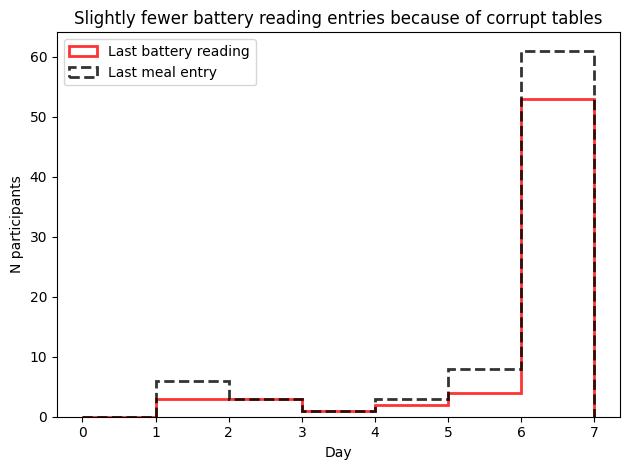

In [10]:
fig, axis = plt.subplots()

hist_kw = {"bins": range(8), "histtype": "step", "linewidth": 2, "alpha": 0.8}
axis.hist(max_delta.dt.days, **hist_kw, color="r", label="Last battery reading")
axis.hist(
    last_entry.dt.days, **hist_kw, linestyle="--", color="k", label="Last meal entry"
)
axis.set_xlabel("Day")
axis.set_ylabel("N participants")
axis.legend()
axis.set_title("Slightly fewer battery reading entries because of corrupt tables")

fig.tight_layout()
fig.savefig(f"{imgdir}/last_meal_entry.png")

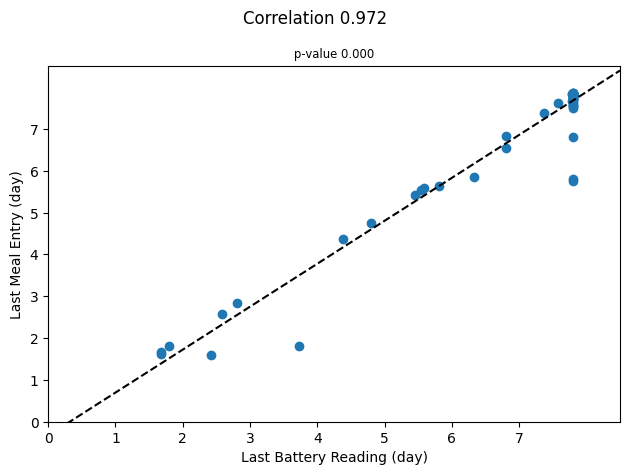

In [11]:
"""
Scatter plot showing the last meal entry vs last battery reading

"""

from scipy.stats import pearsonr

last_entry_df = (
    pd.DataFrame(max_delta)
    .merge(last_entry, on="p_id", how="left")
    .rename(columns={"delta_x": "last_battery", "delta_y": "last_entry"})
)

fig, axis = plt.subplots()
axis.scatter(
    last_entry_df["last_battery"].dt.total_seconds(),
    last_entry_df["last_entry"].dt.total_seconds(),
)

# Fit and plot a line
coefs = np.polyfit(
    last_entry_df["last_battery"].dt.total_seconds(),
    last_entry_df["last_entry"].dt.total_seconds(),
    1,
)
x_values = np.linspace(0, 8.5) * 24 * 3600
y_values = np.poly1d(coefs)(x_values)
axis.plot(x_values, y_values, "--", color="k")

axis.set_xticks(np.arange(8) * 24 * 3600, range(8))
axis.set_yticks(np.arange(8) * 24 * 3600, range(8))

axis.set_xlim(0, 8.5 * 24 * 3600)
axis.set_ylim(0, 8.5 * 24 * 3600)

axis.set_xlabel("Last Battery Reading (day)")
axis.set_ylabel("Last Meal Entry (day)")

# Calculate the Pearson correlation coefficient and the p-value
correlation, p_value = pearsonr(
    last_entry_df["last_battery"].dt.total_seconds(),
    last_entry_df["last_entry"].dt.total_seconds(),
)

fig.suptitle(f"Correlation {correlation:.3f}")
axis.set_title(f"p-value {p_value:.3f}", fontsize="small")

fig.tight_layout()
fig.savefig(f"{imgdir}/last_meal_vs_battery.png")

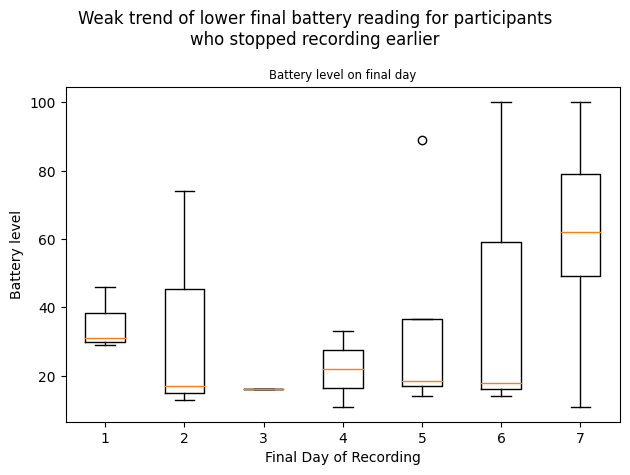

In [12]:
"""
Plot the battery level against final day

"""

fig, axis = plt.subplots()

deltas = []
battery_lvls = []
for _, group in battery_df.groupby("p_id"):
    row = group.loc[group["delta"].idxmax()]
    deltas.append(row["delta"].days)
    battery_lvls.append(row["battery_lvl"])

# Box plot for each day
for day in np.unique(deltas):
    axis.boxplot(
        [battery_lvls[i] for i, delta in enumerate(deltas) if delta == day],
        positions=[day],
        widths=0.5,
    )

axis.set_xlabel("Final Day of Recording")
axis.set_ylabel("Battery level")

axis.set_title("Battery level on final day", fontsize="small")
fig.suptitle(
    "Weak trend of lower final battery reading for participants\nwho stopped recording earlier"
)

fig.tight_layout()
fig.savefig(f"{imgdir}/final_battery_reading.png")

In [13]:
"""
Scatter plot showing number of entries per day vs battery level on that day, colour coded by day

"""

both_df = []

for p_id in tqdm(battery_df["p_id"].unique()):
    tmp_dfs = []
    battery_this_pid = battery_df[battery_df["p_id"] == p_id]
    entries_this_pid = meal_df[meal_df["p_id"] == p_id]
    total_entries = len(entries_this_pid)

    # Find the number of days this participant recorded for
    n_days = battery_this_pid["delta"].dt.days.max()

    for i in range(n_days + 1):
        # Find the number of entries per day
        entries_on_this_day = entries_this_pid[entries_this_pid["delta"].dt.days == i]
        battery_on_this_day = battery_this_pid[battery_this_pid["delta"].dt.days == i]
        n_entries = len(entries_on_this_day)

        # Find the average battery level per day
        avg_battery_lvl = battery_on_this_day["battery_lvl"].mean()

        tmp_dfs.append(
            pd.DataFrame(
                {
                    "p_id": [p_id],
                    "day": [i],
                    "avg_battery_lvl": [avg_battery_lvl],
                    "n_entries": [n_entries],
                }
            )
        )

    both_df.append(pd.concat(tmp_dfs))

both_df = pd.concat(both_df)
both_df.head()

100%|██████████| 66/66 [00:00<00:00, 130.49it/s]


,p_id,day,avg_battery_lvl,n_entries
0,765,0,NaN,0
0,765,1,53.750000,11
0,765,2,85.833333,6
0,765,3,77.166667,9
0,765,4,67.333333,10


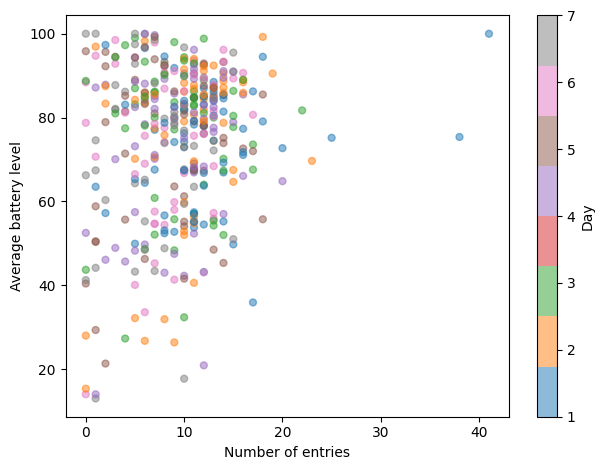

In [14]:
"""
Scatter plot of avg battery level vs n entries, colour coded by day

"""

from matplotlib.colors import ListedColormap

cmap = plt.get_cmap("tab10")
cmap = ListedColormap(cmap(range(cmap.N))[:8])

fig, axis = plt.subplots()

scatter_params = {"alpha": 0.5, "cmap": cmap, "s": 25}
axis.scatter(
    both_df["n_entries"], both_df["avg_battery_lvl"], c=both_df["day"], **scatter_params
)
axis.set_xlabel("Number of entries")
axis.set_ylabel("Average battery level")

fig.colorbar(axis.collections[0], label="Day")

fig.tight_layout()
fig.savefig(f"{imgdir}/avg_battery_vs_n_entries.png")

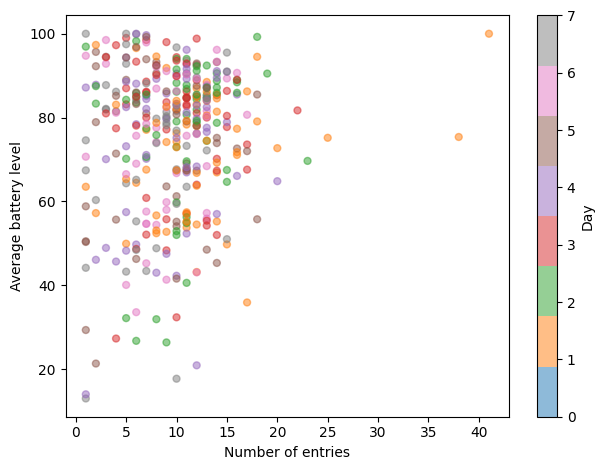

In [15]:
"""
Repeat removing 0 entry days

"""

fig, axis = plt.subplots()

both_df_no0 = both_df[both_df["n_entries"] > 0]

axis.scatter(
    both_df_no0["n_entries"],
    both_df_no0["avg_battery_lvl"],
    c=both_df_no0["day"],
    **scatter_params,
    vmin=0,
)
axis.set_xlabel("Number of entries")
axis.set_ylabel("Average battery level")

fig.colorbar(axis.collections[0], label="Day")

fig.tight_layout()
fig.savefig(f"{imgdir}/avg_battery_vs_n_entries_zero_removed.png")

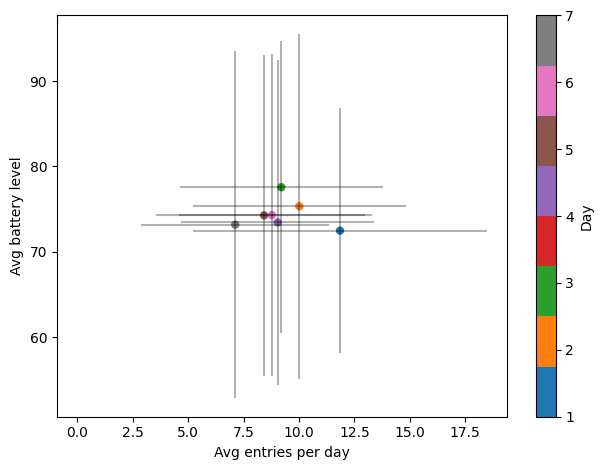

In [16]:
"""
Average over participants and days

"""

grouped_df = both_df.groupby("day").mean()
err_df = both_df.groupby("day").std()
fig, axis = plt.subplots()
axis.errorbar(
    grouped_df["n_entries"],
    grouped_df["avg_battery_lvl"],
    xerr=err_df["n_entries"],
    yerr=err_df["avg_battery_lvl"],
    fmt="none",
    c="k",
    alpha=0.3,
)

scatter_params["alpha"] = 1
axis.scatter(
    grouped_df["n_entries"],
    grouped_df["avg_battery_lvl"],
    c=grouped_df.index,
    **scatter_params,
)
fig.colorbar(axis.collections[-1], label="Day")

axis.set_xlabel("Avg entries per day")
axis.set_ylabel("Avg battery level")

fig.tight_layout()
fig.savefig(f"{imgdir}/avg_battery_vs_n_entries_avgd.png")

In [17]:
"""
Add demographic information to the df

"""

demographic_df = read.full_questionnaire()
demographic_df = demographic_df[demographic_df["respondent_status"] == 1]

demographic_df = both_df.merge(
    demographic_df[
        ["respondent_sex", "respondent_ethnicity", "age_dob", "residents_id"]
    ],
    left_on="p_id",
    right_on="residents_id",
    how="left",
)

# Make it easier by just reading in the cleaned smartwatch data, and using that to tell us about the ramadan status
cleaned_sw = clean.cleaned_smartwatch(keep_catchups=False)

demographic_df = demographic_df.merge(
    cleaned_sw[["p_id", "all_in_ramadan", "any_in_ramadan"]], on="p_id"
)
demographic_df.head()

,p_id,day,avg_battery_lvl,n_entries,respondent_sex,respondent_ethnicity,age_dob,residents_id,all_in_ramadan,any_in_ramadan
0,765,0,NaN,0,1.0,1.0,17.0,765,True,True
1,765,0,NaN,0,1.0,1.0,17.0,765,True,True
2,765,0,NaN,0,1.0,1.0,17.0,765,True,True
3,765,0,NaN,0,1.0,1.0,17.0,765,True,True
4,765,0,NaN,0,1.0,1.0,17.0,765,True,True


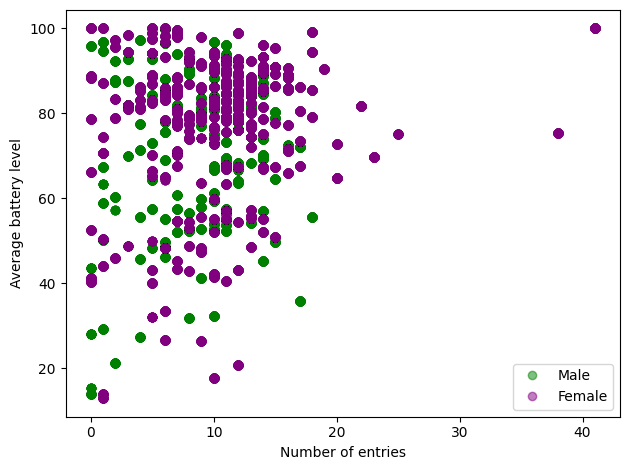

In [18]:
fig, axis = plt.subplots()

axis.plot(
    demographic_df[demographic_df["respondent_sex"] == 1]["n_entries"],
    demographic_df[demographic_df["respondent_sex"] == 1]["avg_battery_lvl"],
    marker="o",
    linestyle="None",
    color="green",
    alpha=0.5,
    label="Male",
)
axis.plot(
    demographic_df[demographic_df["respondent_sex"] == 2]["n_entries"],
    demographic_df[demographic_df["respondent_sex"] == 2]["avg_battery_lvl"],
    marker="o",
    linestyle="None",
    color="purple",
    alpha=0.5,
    label="Female",
)

axis.set_xlabel("Number of entries")
axis.set_ylabel("Average battery level")

axis.legend()

fig.tight_layout()
fig.savefig(f"{imgdir}/avg_battery_sex_separated.png")

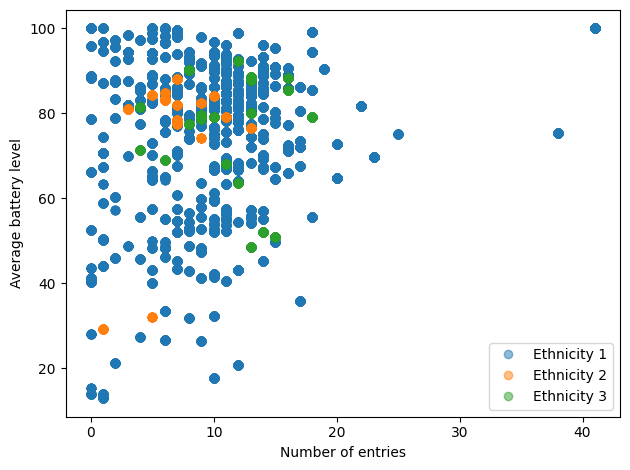

In [19]:
fig, axis = plt.subplots()

for label in demographic_df["respondent_ethnicity"].unique():
    axis.plot(
        demographic_df[demographic_df["respondent_ethnicity"] == label]["n_entries"],
        demographic_df[demographic_df["respondent_ethnicity"] == label][
            "avg_battery_lvl"
        ],
        marker="o",
        linestyle="None",
        alpha=0.5,
        label=f"Ethnicity {int(label)}",
    )

axis.set_xlabel("Number of entries")
axis.set_ylabel("Average battery level")

axis.legend()

fig.tight_layout()
fig.savefig(f"{imgdir}/avg_battery_ethnicity_separated.png")

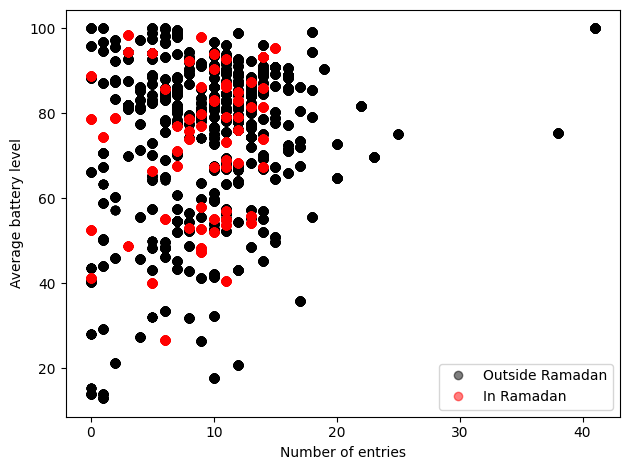

In [20]:
"""
Split by Ramadan status

"""

fig, axis = plt.subplots()

axis.plot(
    demographic_df[~demographic_df["all_in_ramadan"]]["n_entries"],
    demographic_df[~demographic_df["all_in_ramadan"]]["avg_battery_lvl"],
    marker="o",
    linestyle="None",
    color="k",
    alpha=0.5,
    label="Outside Ramadan",
)
axis.plot(
    demographic_df[demographic_df["all_in_ramadan"]]["n_entries"],
    demographic_df[demographic_df["all_in_ramadan"]]["avg_battery_lvl"],
    marker="o",
    linestyle="None",
    color="red",
    alpha=0.5,
    label="In Ramadan",
)

axis.set_xlabel("Number of entries")
axis.set_ylabel("Average battery level")

axis.legend()

fig.tight_layout()
fig.savefig(f"{imgdir}/avg_battery_ramadan_separated.png")

In [21]:
"""
Find how many charge/de-charge periods there are

"""

tmp_df = read.full_questionnaire()
tmp_df = tmp_df[tmp_df["respondent_status"] == 1]

battery_df = battery_df.merge(
    tmp_df[["respondent_sex", "respondent_ethnicity", "age_dob", "residents_id"]],
    left_on="p_id",
    right_on="residents_id",
    how="left",
)

# Make it easier by just reading in the cleaned smartwatch data, and using that to tell us about the ramadan status
cleaned_sw = clean.cleaned_smartwatch(keep_catchups=False)
demographic_df = battery_df.merge(
    cleaned_sw[["p_id", "all_in_ramadan", "any_in_ramadan"]], on="p_id"
)
battery_df.head()

,p_id,battery_lvl,delta,respondent_sex,respondent_ethnicity,age_dob,residents_id
0,765,72,1 days 08:00:40,1.0,1.0,17.0,765
1,765,69,1 days 09:00:43,1.0,1.0,17.0,765
2,765,64,1 days 10:00:45,1.0,1.0,17.0,765
3,765,60,1 days 11:00:49,1.0,1.0,17.0,765
4,765,57,1 days 12:00:54,1.0,1.0,17.0,765


In [22]:
"""
Plot some time series of battery level, showing numbers of charge/de-charge periods

"""

charges = {}
de_charges = {}
for p_id, group in battery_df.groupby("p_id"):
    assert group["delta"].is_monotonic_increasing

    # Find the sign for the battery level diff
    diff_sign = (
        np.sign(group["battery_lvl"].diff()).replace(0, pd.NA).infer_objects(copy=False)
    )

    # Create a new series where the sign changes, ignoring zero differences
    sign_change = (diff_sign.diff().ne(0) & diff_sign.ne(0)).cumsum()

    # Count the number of charge and de-charge periods
    charges[p_id] = (diff_sign > 0).groupby(sign_change).sum().astype(bool).sum()
    de_charges[p_id] = (diff_sign < 0).groupby(sign_change).sum().astype(bool).sum()

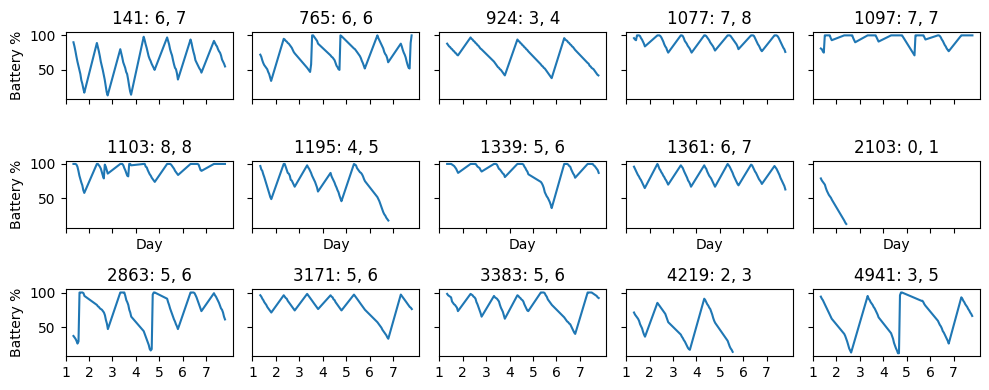

In [23]:
fig, axes = plt.subplots(3, 5, figsize=(10, 4), sharex=True, sharey=True)

for axis, (p_id, grp) in zip(
    axes.flat, islice(battery_df.groupby("p_id"), len(axes.flat))
):
    axis.plot(grp["delta"].dt.total_seconds(), grp["battery_lvl"])
    axis.set_title(f"{p_id}: {charges[p_id]}, {de_charges[p_id]}")

for axis in axes[:, 0]:
    axis.set_ylabel("Battery %")
for axis in axes[1]:
    axis.set_xlabel("Day")

# Convert x labels to days
axis.set_xticks(np.arange(1, 8) * 24 * 3600, range(1, 8))

fig.tight_layout()
fig.savefig(f"{imgdir}/battery_level_n_periods.png")

In [24]:
"""
Create a number of charge/discharge periods dataframe

"""

for a, b in zip(charges.items(), de_charges.items()):
    p_id = a[0]
    assert p_id == b[0]

charge_df = pd.DataFrame(
    {
        "p_id": charges.keys(),
        "n_charges": charges.values(),
        "n_discharges": de_charges.values(),
    }
)
charge_df.head()

,p_id,n_charges,n_discharges
0,141,6,7
1,765,6,6
2,924,3,4
3,1077,7,8
4,1097,7,7


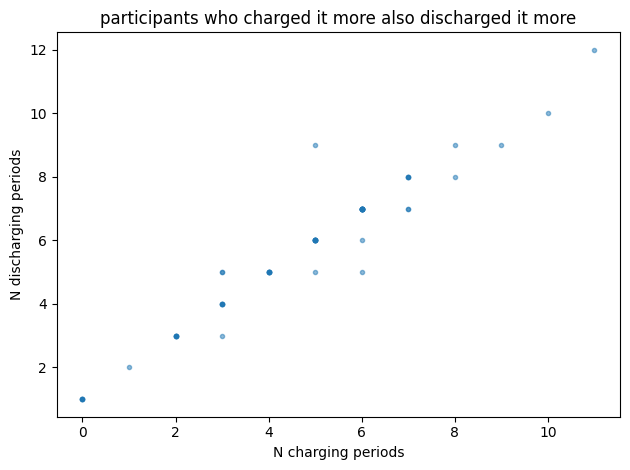

In [25]:
"""
Plot them against each other

"""

fig, axis = plt.subplots()

axis.plot(charge_df["n_charges"], charge_df["n_discharges"], ".", alpha=0.5)

axis.set_title("participants who charged it more also discharged it more")
axis.set_xlabel("N charging periods")
axis.set_ylabel("N discharging periods")

fig.tight_layout()
fig.savefig(f"{imgdir}/n_charge_vs_n_discharge.png")

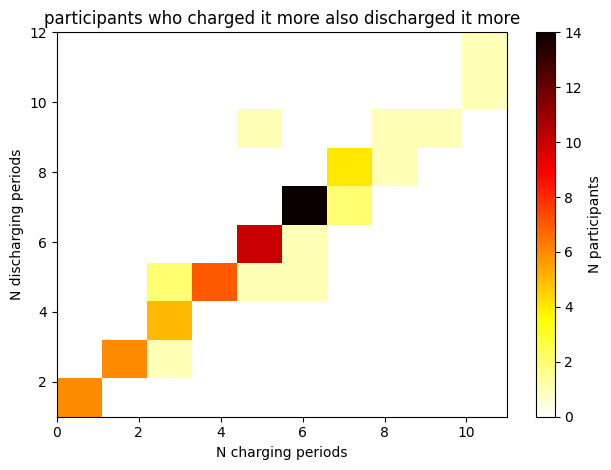

In [26]:
fig, axis = plt.subplots()

axis.hist2d(
    charge_df.drop_duplicates()["n_charges"],
    charge_df.drop_duplicates()["n_discharges"],
    bins=10,
    cmap="hot_r",
)

axis.set_title("participants who charged it more also discharged it more")
axis.set_xlabel("N charging periods")
axis.set_ylabel("N discharging periods")

fig.colorbar(axis.collections[0], label="N participants")

fig.tight_layout()
fig.savefig(f"{imgdir}/n_charge_vs_n_discharge_hist.png")

In [27]:
"""
Add demographic information to the df

"""

if "respondent_sex" not in charge_df.columns:
    tmp_df = read.full_questionnaire()
    tmp_df = tmp_df[tmp_df["respondent_status"] == 1]

    charge_df = charge_df.merge(
        tmp_df[["respondent_sex", "respondent_ethnicity", "age_dob", "residents_id"]],
        left_on="p_id",
        right_on="residents_id",
        how="left",
    )

    # Make it easier by just reading in the cleaned smartwatch data, and using that to tell us about the ramadan status
    cleaned_sw = clean.cleaned_smartwatch(keep_catchups=False)

    charge_df = charge_df.merge(
        cleaned_sw[["p_id", "all_in_ramadan", "any_in_ramadan"]], on="p_id"
    )
charge_df.drop_duplicates(inplace=True)
charge_df.head()

,p_id,n_charges,n_discharges,respondent_sex,respondent_ethnicity,age_dob,residents_id,all_in_ramadan,any_in_ramadan
0,141,6,7,2.0,1.0,9.0,141,True,True
87,765,6,6,1.0,1.0,17.0,765,True,True
181,924,3,4,2.0,3.0,17.0,924,False,False
297,1077,7,8,2.0,1.0,14.0,1077,False,False
403,1097,7,7,2.0,1.0,13.0,1097,False,False


In [28]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(
    charge_df[charge_df["respondent_sex"] == 1.0]["n_charges"],
    charge_df[charge_df["respondent_sex"] == 2.0]["n_charges"],
)

t_stat, p_val

(-1.284567534822697, 0.20357365507481226)

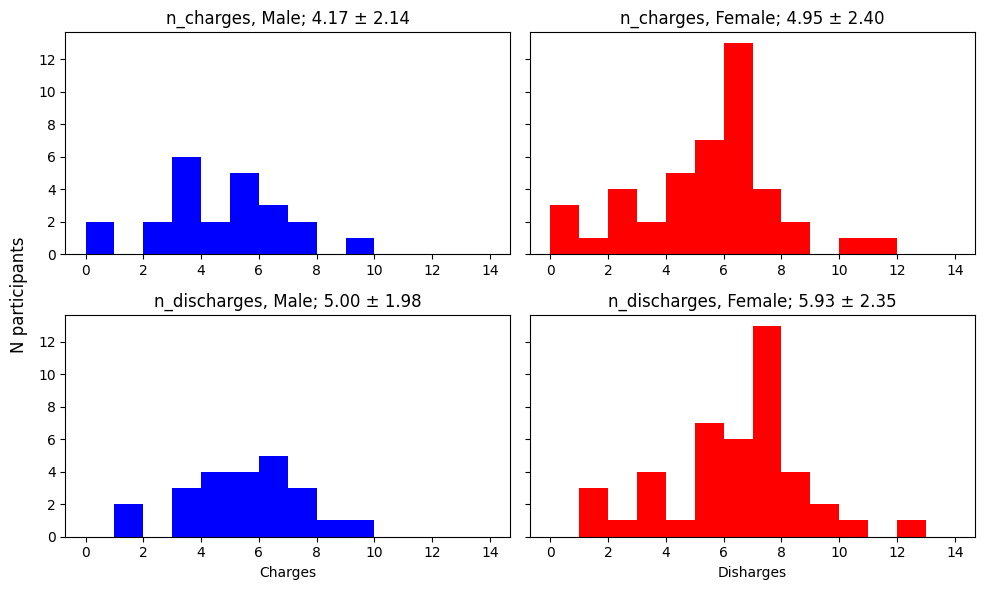

In [29]:
"""
Histograms of charge + discharge periods

"""

fig, axes = plt.subplots(2, 2, sharey=True, figsize=(10, 6))

hist_kw = {
    "bins": range(15),
    "histtype": "stepfilled",
    "linewidth": 2,
    "alpha": 1,
    "density": False,
}
for axs, col in zip(axes, ["n_charges", "n_discharges"]):
    for axis, sex in zip(axs, [1.0, 2.0]):
        data = charge_df[charge_df["respondent_sex"] == sex][col]
        axis.hist(data, **hist_kw, color="b" if sex == 1.0 else "r")

        mean, std = np.mean(data), np.std(data)
        axis.set_title(
            f"{col}, {'Male' if sex == 1.0 else 'Female'}; {mean:.2f} ± {std:.2f}"
        )

fig.supylabel("N participants")


axes[1, 0].set_xlabel("Charges")
axes[1, 1].set_xlabel("Disharges")

fig.tight_layout()
fig.savefig(f"{imgdir}/n_charge_discharge_hist.png")

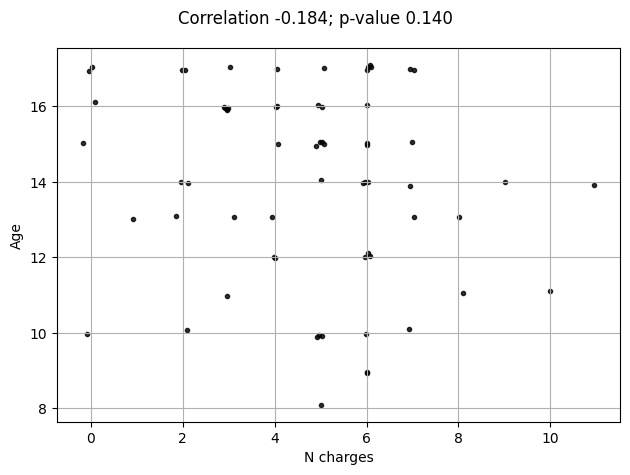

In [30]:
"""
Correlation between age and number of charge/discharge periods

"""

from scipy.stats import pearsonr

corr, p_val = pearsonr(charge_df["n_charges"], charge_df["age_dob"])

fig, axis = plt.subplots()
axis.grid("on")
axis.scatter(
    charge_df["n_charges"] + 0.3 * np.random.normal(0, 0.2, len(charge_df)),
    charge_df["age_dob"] + 0.3 * np.random.normal(0, 0.2, len(charge_df)),
    s=9,
    alpha=0.8,
    color="k",
)
axis.set_xlabel("N charges")
axis.set_ylabel("Age")

fig.suptitle(f"Correlation {corr:.3f}; p-value {p_val:.3f}")
fig.tight_layout()

fig.savefig(f"{imgdir}/n_charge_vs_age.png")

In [31]:
"""
Come up with some metric that says whether each participant stopped using the battery due to low charge

"""

battery_threshold = 25

battery_df["early_stop"] = False
battery_df["low_battery_end"] = False

# Find the delta on the last day
for p_id in charge_df["p_id"].unique():
    slice_df = battery_df[battery_df["p_id"] == p_id]
    assert slice_df["delta"].is_monotonic_increasing

    # Find if this participant stopped early
    early_stop = slice_df["delta"].dt.days.max() < 7

    # Find if they ended on low battery
    low_battery_end = slice_df["battery_lvl"].iloc[-1] < battery_threshold

    battery_df.loc[battery_df["p_id"] == p_id, "early_stop"] = early_stop
    battery_df.loc[battery_df["p_id"] == p_id, "low_battery_end"] = low_battery_end


battery_df["discharged"] = battery_df["early_stop"] & battery_df["low_battery_end"]

,p_id,battery_lvl,delta,respondent_sex,respondent_ethnicity,age_dob,residents_id,early_stop,low_battery_end,discharged
0,765,72,1 days 08:00:40,1.0,1.0,17.0,765,False,False,False
1,765,69,1 days 09:00:43,1.0,1.0,17.0,765,False,False,False
2,765,64,1 days 10:00:45,1.0,1.0,17.0,765,False,False,False
3,765,60,1 days 11:00:49,1.0,1.0,17.0,765,False,False,False
4,765,57,1 days 12:00:54,1.0,1.0,17.0,765,False,False,False
...,...,...,...,...,...,...,...,...,...,...
4610,9891,100,7 days 15:11:01,2.0,2.0,17.0,9891,False,False,False
4611,9891,98,7 days 16:11:23,2.0,2.0,17.0,9891,False,False,False
4612,9891,95,7 days 17:13:23,2.0,2.0,17.0,9891,False,False,False
4613,9891,93,7 days 18:15:23,2.0,2.0,17.0,9891,False,False,False


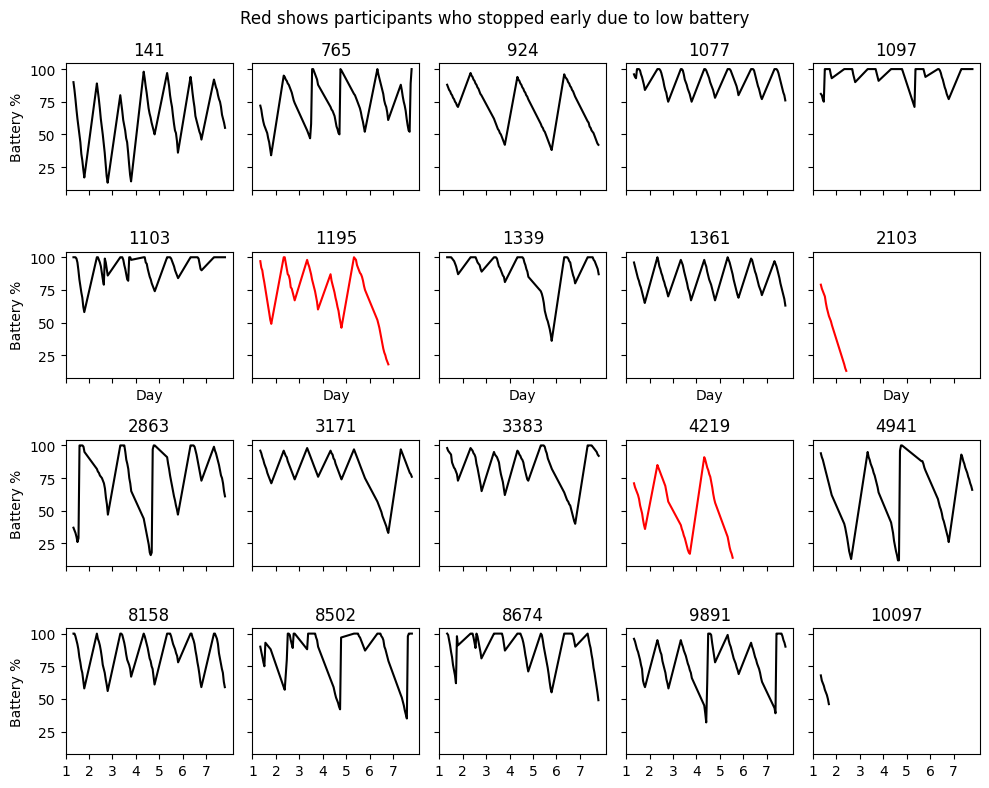

In [32]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True, sharey=True)

for axis, (p_id, grp) in zip(
    axes.flat, islice(battery_df.groupby("p_id"), len(axes.flat))
):
    assert grp["discharged"].nunique() == 1

    axis.plot(
        grp["delta"].dt.total_seconds(),
        grp["battery_lvl"],
        color="r" if grp["discharged"].iloc[0] else "k",
    )
    axis.set_title(p_id)

for axis in axes[:, 0]:
    axis.set_ylabel("Battery %")
for axis in axes[1]:
    axis.set_xlabel("Day")

# Convert x labels to days
axis.set_xticks(np.arange(1, 8) * 24 * 3600, range(1, 8))

fig.suptitle("Red shows participants who stopped early due to low battery")
fig.tight_layout()
fig.savefig(f"{imgdir}/battery_level_vs_delta_discharged.png")

In [38]:
"""
For those who ended early, plot their battery level + indicate the last meal entry + subsequent no responses

"""
print(battery_df["early_stop"].value_counts())

early_stop
False    4012
True      603
Name: count, dtype: int64


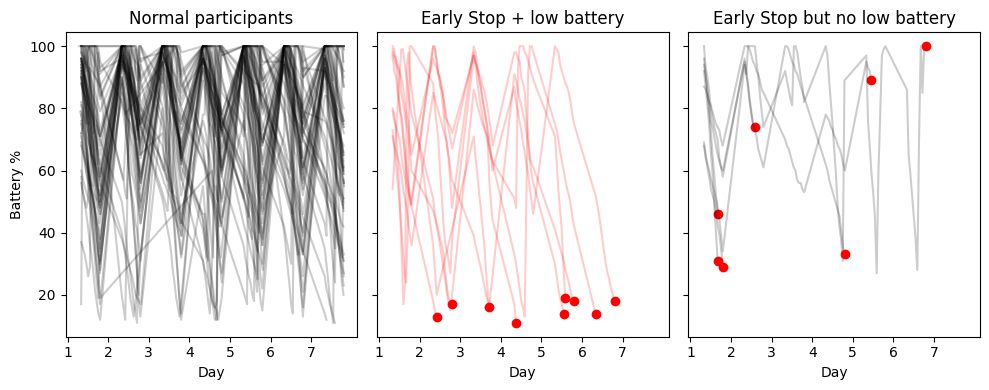

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)

for p_id, grp in battery_df.groupby("p_id"):
    assert grp["discharged"].nunique() == 1

    # Plot the different ones on different axes
    if grp["discharged"].iloc[0]:
        axis = axes[1]
    elif grp["early_stop"].iloc[0]:
        axis = axes[2]
    else:
        axis = axes[0]

    axis.plot(
        grp["delta"].dt.total_seconds(),
        grp["battery_lvl"],
        color="r" if grp["discharged"].iloc[0] else "k",
        alpha=0.2,
    )

    # Mark the end point
    if axis != axes[0]:
        axis.plot(
            grp["delta"].dt.total_seconds().iloc[-1], grp["battery_lvl"].iloc[-1], "ro"
        )

for axis in axes:
    axis.set_xlabel("Day")
axes[0].set_ylabel("Battery %")

# Convert x labels to days
for axis in axes:
    axis.set_xticks(np.arange(1, 8) * 24 * 3600, range(1, 8))

axes[0].set_title("Normal participants")
axes[1].set_title("Early Stop + low battery")
axes[2].set_title("Early Stop but no low battery")


fig.tight_layout()
fig.savefig(f"{imgdir}/charged_vs_discharged.png")

In [34]:
"""
Create a dataframe that just has one entry per participant

"""

last_entry_df = battery_df.groupby("p_id").last()

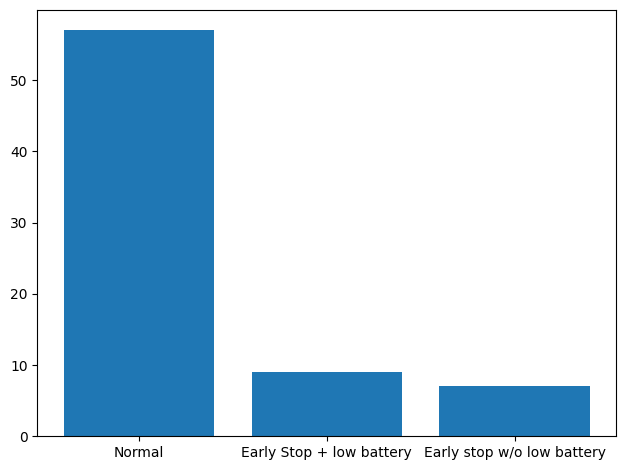

In [35]:
fig, axis = plt.subplots()

axis.bar(
    ["Normal", "Early Stop + low battery", "Early stop w/o low battery"],
    [
        (~last_entry_df["discharged"]).sum(),
        (last_entry_df["discharged"]).sum(),
        (last_entry_df["early_stop"] & ~last_entry_df["low_battery_end"]).sum(),
    ],
)

fig.tight_layout()
fig.savefig(f"{imgdir}/charged_vs_discharged_bar.png")

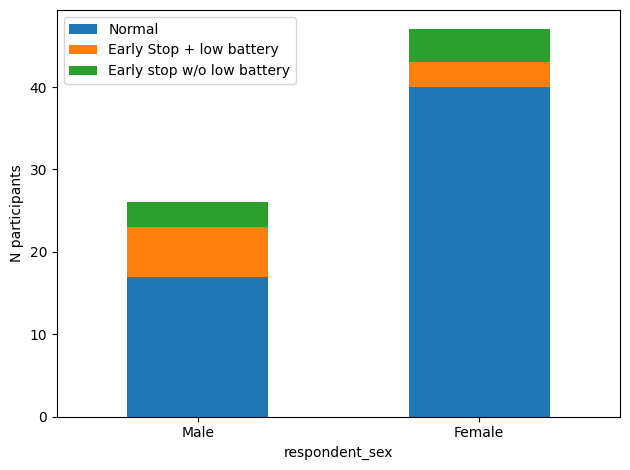

In [36]:
# Define the categories
last_entry_df["Normal"] = ~last_entry_df["discharged"]
last_entry_df["Early Stop + low battery"] = last_entry_df["discharged"]
last_entry_df["Early stop w/o low battery"] = (
    last_entry_df["early_stop"] & ~last_entry_df["low_battery_end"]
)

# Group by respondent_sex and calculate the sums for each category
grouped = last_entry_df.groupby("respondent_sex").agg(
    {
        "Normal": "sum",
        "Early Stop + low battery": "sum",
        "Early stop w/o low battery": "sum",
    }
)

# Plot the stacked bar chart
fig, axis = plt.subplots()
grouped.plot(kind="bar", stacked=True, ax=axis)
axis.set_xticklabels(["Male", "Female"], rotation=0)
axis.set_ylabel("N participants")

fig.tight_layout()
fig.savefig(f"{imgdir}/charged_vs_discharged_bar_sex.png")

In [37]:
""" See if these are different """

from scipy.stats import chi2_contingency

n_male = num_males_early_stop_low_battery = [
    len(last_entry_df[(last_entry_df["respondent_sex"] == 1.0) & (last_entry_df[col])])
    for col in ("Normal", "Early Stop + low battery", "Early stop w/o low battery")
]
n_female = [
    len(last_entry_df[(last_entry_df["respondent_sex"] == 2.0) & (last_entry_df[col])])
    for col in ("Normal", "Early Stop + low battery", "Early stop w/o low battery")
]

chi2, p, dof, expected = chi2_contingency([n_male, n_female])
chi2, p, dof, expected

(4.777852979420727,
 0.09172810210302078,
 2,
 array([[20.30136986,  3.20547945,  2.49315068],
        [36.69863014,  5.79452055,  4.50684932]]))